In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
# import nltk 

In [17]:
!pip install -U nltk

     |████████████████████████████████| 1.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 6.0 MB/s eta 0:00:01
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.1
    Uninstalling nltk-3.6.1:
      Successfully uninstalled nltk-3.6.1


In [2]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sonnguyen2k/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [6]:
base_csv = './input/full_train.csv'
df = pd.read_csv(base_csv)
df = df[df.Comment == df.Comment]
df = df[df.Rating == df.Rating]
df.head()

,Unnamed: 0,RevId,UserId,Comment,image_urls,Rating
0,0,3839333,10106093.0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",['https://images.foody.vn/res/g97/966781/s800/...,1.0
1,1,2824877,786914.0,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,['https://images.foody.vn/res/g69/688413/s800/...,0.0
2,2,9816702,22467889.0,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",['https://images.foody.vn/res/g72/715078/s800/...,1.0
3,3,2684585,1889449.0,Em có đọc review thấy mng bảo trà sữa nướng đề...,['https://images.foody.vn/res/g90/895545/s800/...,0.0
4,4,2737987,8839942.0,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",['https://images.foody.vn/res/g4/30186/s800/fo...,1.0


In [7]:
X,y = df['Comment'].values,df['Rating'].values
print(X, y)
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

['Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trông rất thích'
 'Gọi ship 1 xuất cari gà bánh naan và 3 miếng gà nướng(được tặng 1 coca). Đồ ăn khá ngon, tổng 210k được giảm 50k còn 160k. Tuy nhiên gọi 3 miếng gà thì thiếu 1 miếng, mà kể cả đó đủ ba miếng thì khẩu phần vẫn là quá ít so với giá 120k 1 suất.'
 'Thời tiết lạnh như này, cả nhà rủ nhau đến legarden thì hết ý. Nhà mình đã ăn ở đây nhiều rồi rất ưng thái độ phục vụ của các bạn nhân viên, tận tình như người nhà. Đồ ăn thì miễn bàn mình chưa tìm được quán ăn hồng kong nào chuẩn vị như ở đây'
 ...
 'Ngay từ lúc đầu tiên bước vào nhà hàng đã được nhân viên đón tiếp rất nhiệt tình. Rất ấn tượng với cách chăm sóc khách hàng của nhân viên ở đây. Luôn nhiệt tình và ân cần với khách hàng. Nhà hàng cũng được trang trí rất đẹp mắt. Chắc chắn sẽ quay lại. Và sẽ giới thiệu bạn bè tới đây.'
 'Đặt ăn thử mà thấy ngón cá...! 🤩 sẽ còn ủn hộ quán nhìu nhìu.'
 'Nay xem bóng đá VN lười nấu cơm. Nghe các bạn giới thiệu mỳ ý chỗ này siêu ngon, giá 

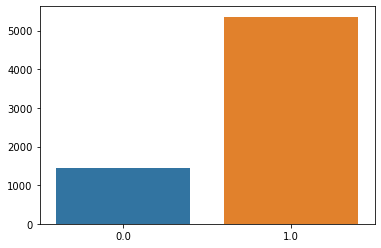

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([1.0,0.0]),y=dd.values)
plt.show()

In [33]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [34]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
print(x_train)
print('===')
print(y_train)
print('===')
print(x_test)
print('===')
print(y_test)
print('===')

AttributeError: 'list' object has no attribute 'lower'

In [11]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


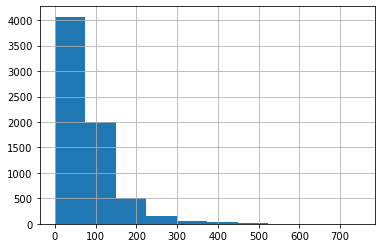

count    6802.000000
mean       75.469421
std        67.195628
min         0.000000
25%        28.000000
50%        58.000000
75%       102.000000
max       747.000000
dtype: float64

In [12]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [13]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [14]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)
print(x_train_pad)
print('===')
print(x_test_pad)

[[  0   0   0 ...   0   0  46]
 [  0   0   0 ...  14 276 372]
 [  0   0   0 ...  69  71  68]
 ...
 [  0   0   0 ...  19 564 576]
 [  0   0   0 ... 743  30 122]
 [  0   0   0 ... 467 151  56]]
===
[[  0   0   0 ...  54 113  21]
 [  0   0   0 ... 697 161  22]
 [  0   0   0 ...   1 212 623]
 ...
 [  0   0   0 ...   1  10   9]
 [  0   0   0 ... 296  29   5]
 [  0   0   0 ...  35 113  21]]


In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
print(train_data)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

from torch.autograd import Variable
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# for i, (inputs, targets) in enumerate(train_loader):
#     with torch.no_grad():
#         inputs = Variable(inputs)
#         targets = Variable(targets)
#         print("targets.data", targets)
#         print("inputs.data", inputs)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [16]:
# obtain one batch of training data
print(train_loader)
dataiter = iter(train_loader)
print(dataiter)
# sample_x, sample_y = dataiter.next()
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  17,  11,   3],
        [  0,   0,   0,  ...,  11,  29,  62],
        [  0,   0,   0,  ..., 108,  18,   1],
        ...,
        [  0,   0,   0,  ..., 912, 126, 279],
        [  0,   0,   0,  ...,  96,  21,  68],
        [  0,   0,   0,  ..., 113,  13,  17]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [17]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [18]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
print(vocab_size)
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

1001
SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [19]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [24]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        print('jjj===')
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        try:
          output,h = model(inputs,h)
        except:
          continue
        
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        print(accuracy, train_acc)
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    print('aaa')
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            print('ccc')
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            try:
                output, val_h = model(inputs, val_h)
            except:
                continue
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

jjj===
50 50.0
jjj===
50 100.0
jjj===
50 150.0
jjj===
50 200.0
jjj===
50 250.0
jjj===
50 300.0
jjj===
50 350.0
jjj===
50 400.0
jjj===
50 450.0
jjj===
50 500.0
jjj===
50 550.0
jjj===
50 600.0
jjj===
50 650.0
jjj===
50 700.0
jjj===
50 750.0
jjj===
50 800.0
jjj===
50 850.0
jjj===
50 900.0
jjj===
50 950.0
jjj===
50 1000.0
jjj===
50 1050.0
jjj===
50 1100.0
jjj===
50 1150.0
jjj===
50 1200.0
jjj===
50 1250.0
jjj===
50 1300.0
jjj===
50 1350.0
jjj===
50 1400.0
jjj===
50 1450.0
jjj===
50 1500.0
jjj===
50 1550.0
jjj===
50 1600.0
jjj===
50 1650.0
jjj===
50 1700.0
jjj===
50 1750.0
jjj===
50 1800.0
jjj===
50 1850.0
jjj===
50 1900.0
jjj===
50 1950.0
jjj===
50 2000.0
jjj===
50 2050.0
jjj===
50 2100.0
jjj===
50 2150.0
jjj===
50 2200.0
jjj===
50 2250.0
jjj===
50 2300.0
jjj===
50 2350.0
jjj===
50 2400.0
jjj===
50 2450.0
jjj===
50 2500.0
jjj===
50 2550.0
jjj===
50 2600.0
jjj===
50 2650.0
jjj===
50 2700.0
jjj===
50 2750.0
jjj===
50 2800.0
jjj===
50 2850.0
jjj===
50 2900.0
jjj===
50 2950.0
jjj===
50 3000.0


50 50.0
jjj===
50 100.0
jjj===
50 150.0
jjj===
50 200.0
jjj===
50 250.0
jjj===
50 300.0
jjj===
50 350.0
jjj===
50 400.0
jjj===
50 450.0
jjj===
50 500.0
jjj===
50 550.0
jjj===
50 600.0
jjj===
50 650.0
jjj===
50 700.0
jjj===
50 750.0
jjj===
50 800.0
jjj===
50 850.0
jjj===
50 900.0
jjj===
50 950.0
jjj===
50 1000.0
jjj===
50 1050.0
jjj===
50 1100.0
jjj===
50 1150.0
jjj===
50 1200.0
jjj===
50 1250.0
jjj===
50 1300.0
jjj===
50 1350.0
jjj===
50 1400.0
jjj===
50 1450.0
jjj===
50 1500.0
jjj===
50 1550.0
jjj===
50 1600.0
jjj===
50 1650.0
jjj===
50 1700.0
jjj===
50 1750.0
jjj===
50 1800.0
jjj===
50 1850.0
jjj===
50 1900.0
jjj===
50 1950.0
jjj===
50 2000.0
jjj===
50 2050.0
jjj===
50 2100.0
jjj===
50 2150.0
jjj===
50 2200.0
jjj===
50 2250.0
jjj===
50 2300.0
jjj===
50 2350.0
jjj===
50 2400.0
jjj===
50 2450.0
jjj===
50 2500.0
jjj===
50 2550.0
jjj===
50 2600.0
jjj===
50 2650.0
jjj===
50 2700.0
jjj===
50 2750.0
jjj===
50 2800.0
jjj===
50 2850.0
jjj===
50 2900.0
jjj===
50 2950.0
jjj===
50 3000.0
jjj===


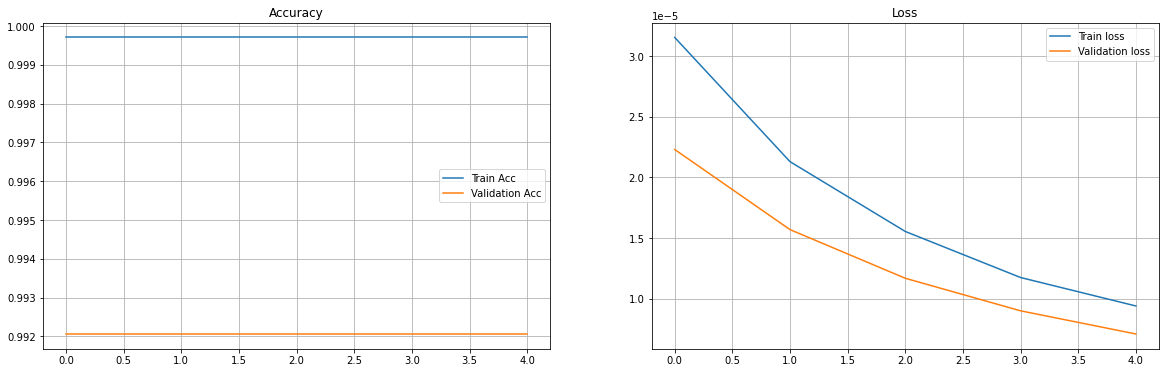

In [25]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [26]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [31]:
index = 33
print(df['Comment'][index])
print('='*70)
print(f'Actual sentiment is  : {df["Rating"][index]}')
print('='*70)
pro = predict_text(df['Comment'][index])
print(pro)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Mình đi chỗ này hình như là 2 lần rồi thì phải :D 
Cả 2 lần đều là vì tham gia sự kiện giới thiệu sản phẩm mới của Sony :))

Quán có không gian siêu đẹp, cả ngoài trời lẫn trong phòng luôn.

Đồ ăn đồ uống thì cũng bình thường thôi, không đặc sắc lắm.
Giá cả thì mình không rõ lắm vì mình được gọi miễn phí do đi tham dự chương trình của sony, chứ không có bỏ tiền ra gọi đồ :3 :D

Nhân viên cũng bình thường, không ấn tượng gì nhiều theo cả 2 hướng tích cực hay tiêu cực.
Actual sentiment is  : 1.0
7.11137727194e-06
Predicted sentiment is negative with a probability of 0.9999928886227281
